Sheets
https://docs.google.com/spreadsheets/d/1KKJ2tckV-vTh8Sf5xL46Wd776om9Kv_Kk2okAR4gEUs/edit#gid=0

Data Studio
https://lookerstudio.google.com/u/0/reporting/97241acc-67c9-4e28-9511-3061e9628f3a/page/2psXD/edit

Study
https://www.khanacademy.org/economics-finance-domain/core-finance/housing/renting-v-buying/v/renting-versus-buying-a-home


# Load the dataframe

In [28]:
import os
os.getcwd() 

import pandas as pd
# import matplotlib.pyplot as plt

In [61]:
# Read the data file into a DataFrame
t_data_file_path = 'sources/transactions.csv'
c_data_file_path = 'sources/Chase8461_Activity20231118.CSV'

t_data = pd.read_csv(t_data_file_path)
c_data = pd.read_csv(c_data_file_path)

# Replace spaces with underscores in column names
t_data.columns = t_data.columns.str.replace(' ', '_')
c_data.columns = c_data.columns.str.replace(' ', '_')

# Convert all text data in the DataFrame to lowercase (done to help w matching rules)
t_data_text_columns = ['Description', 'Original_Description', 'Transaction_Type', 'Category', 'Account_Name', 'Notes']
t_data[t_data_text_columns] = t_data[t_data_text_columns].apply(lambda x: x.astype(str).str.lower())

c_data_text_columns = ['Description','Category','Type','Memo']
c_data[c_data_text_columns] = c_data[c_data_text_columns].apply(lambda x: x.astype(str).str.lower())

# Convert 'Date' column to datetime type with explicit format
t_data['Date'] = pd.to_datetime(t_data['Date'], format='%m/%d/%Y')
c_data['Transaction_Date'] = pd.to_datetime(c_data['Transaction_Date'], format='%m/%d/%Y')
c_data['Post_Date'] = pd.to_datetime(c_data['Post_Date'], format='%m/%d/%Y')

# Extract year and month from the 'Date' column
t_data['Year'] = t_data['Date'].dt.year
t_data['Month'] = t_data['Date'].dt.month

# Add outliers column and initialize it as null
t_data['outliers'] = 0

# Strip whitespace from all string columns
t_data = t_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Perform a string replace operation on the "ColumnName" column
t_data['Original_Description'] = t_data['Original_Description'].str.replace('pos purch - ', ' ')
t_data['Description'] = t_data['Original_Description'].str.replace('pos purch - ', ' ')


# Verify the updated data type of the 'Date' column
print("Data type of 'Date' column after conversion:", t_data['Date'].dtype)
print("Data type of 'Date' column after conversion:", c_data['Transaction_Date'].dtype)
print("Data type of 'Date' column after conversion:", c_data['Post_Date'].dtype)


# Add outliers column and initialize it as null
c_data['outliers'] = 0 
# Add Label2 to capture more granular categories
c_data['Labels'] = ''

# Strip whitespace from all string columns
c_data = c_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Remove commas from the some text columns to help avoid loading issues in looker (if used)
t_data['Notes'] = t_data['Notes'].str.replace(',', '')
t_data['Description'] = t_data['Description'].str.replace(',', '')
t_data['Original_Description'] = t_data['Original_Description'].str.replace(',', '')

t_data.head()
c_data.head()

Data type of 'Date' column after conversion: datetime64[ns]
Data type of 'Date' column after conversion: datetime64[ns]
Data type of 'Date' column after conversion: datetime64[ns]


,Transaction_Date,Post_Date,Description,Category,Type,Amount,Memo,outliers,Labels
0,2023-11-14,2023-11-16,baja burrito,food & drink,sale,-21.70,nan,0,
1,2023-11-14,2023-11-15,amazon.com*c11dk1ei3,shopping,sale,-16.72,nan,0,
2,2023-11-14,2023-11-15,amzn mktp us*wp8d95sg3,shopping,sale,-20.75,nan,0,
3,2023-11-13,2023-11-13,axs.comopry ryman tix,entertainment,sale,-162.50,nan,0,
4,2023-11-11,2023-11-13,trader joe s #739,groceries,sale,-127.77,nan,0,


In [62]:
print(t_data.dtypes)

Date                    datetime64[ns]
Description                     object
Original_Description            object
Amount                         float64
Transaction_Type                object
Category                        object
Account_Name                    object
Labels                          object
Notes                           object
Year                             int32
Month                            int32
outliers                         int64
dtype: object


# Transform the data. Create logic to recategorize.

## Custom function to apply recategorization logic

In [77]:
# Define the categorize_categories function
def categorize_categories(df):
    # Create a dictionary to map original categories to new values
    category_mapping = {
        'food': 'food',
        'food & drink': 'food',
        'restaurants': 'food',
        'cafe': 'food',
        'coffee': 'food',
        'coffee shops': 'food',
        'pharmacy': 'food',
        'groceries': 'food',
        'auto': 'auto',
        'gas & fuel': 'auto',
        'food & dining': 'auto',
        'ride share': 'auto',
        'parking': 'auto',
        'rental car & taxi': 'auto',
        'transportation': 'auto',
        'hotel': 'discretionary',
        'venmo': 'discretionary',
        'travel': 'discretionary',
        'entertainment': 'discretionary',
        'amusement': 'discretionary',
        'clothing': 'discretionary',
        'dating': 'discretionary',
        'transfer': 'transfer',
        'concert': 'discretionary',
        'club': 'discretionary',
        'movie': 'discretionary',
        'Dentist': 'utilities',
        'Doctor': 'utilities',
        'Internet': 'utilities',
        'bills': 'utilities',
        'utilities': 'utilities',
        'Life Insurance': 'utilities',
        'bills & utilities': 'utilities',
        'Mobile Phone': 'utilities',
        'business services': 'utilities',
        'Loans': 'loans',
        'alcohol & bars': 'discretionary',
        'gift': 'discretionary',
        'gym': 'investment',
        'auto & transport': 'auto',
        'music': 'discretionary',
        'fast food': 'food',
        'sporting goods': 'discretionary',
        'charity': 'discretionary',
        'books': 'investment',
        'electronics & software': 'discretionary',
        'shopping': 'discretionary',
        'investments': 'investment',
        'paycheck': 'income',
        'personal care': 'discretionary',
        'misc expenses': 'discretionary',
        'fees & charges': 'bills',
        'mortgage & rent': 'bills',
        'venmo payment': 'bills',
        'advertising': 'discretionary',
        'podcast': 'entertainment',
        'arts': 'discretionary',
        'air travel': 'travel',
        'kids': 'discretionary',
        'newspapers & magazines': 'entertainment',
        'federal tax': 'bills',
        'home improvement': 'utilities',
        'books & supplies': 'investment',
        'uncategorized': 'uncategorized',
        'movies & dvds': 'entertainment',
        'health & fitness': 'investment',
        'income': 'discretionary',
        'doctor': 'health',
        'cash & atm': 'bills',
        'office supplies': 'discretionary',
        'spa & massage': 'discretionary',
        'laundry': 'discretionary',
        'auto insurance': 'auto',
        'hair': 'discretionary',
        'shipping': 'discretionary',
        'service & parts': 'auto',
        'bank fee': 'bills',
        'home services': 'utilities',
        'finance charge': 'bills',
        'atm fee': 'bills',
        'life insurance': 'bills',
        'dentist': 'health',
        'public transportation': 'auto',
        'furnishings': 'discretionary',
        'mobile phone': 'bills',
        'home': 'utilities',
        'sports': 'discretionary',
        'gifts & donation': 'discretionary',
        'bitcoin investment': 'investment',
        'gifts & donations': 'discretionary',
        'television': 'entertainment',
        'vacation': 'travel',
        'therapy': 'health',
        'lawn & garden': 'utilities',
        'classes': 'investment',
        'hca cafe': 'food',
        'credit card payments': 'bills',
        'printing': 'discretionary',
        'credit card payment': 'bills',
        'home supplies': 'utilities',
        'kids activities': 'discretionary',
        'education': 'investment',
        'hobbies': 'discretionary',
        'question?': 'uncategorized',
        'financial': 'investment',
        'home phone': 'utilities',
        'auto payment	': 'auto',
        'returned purchase': 'discretionary',
        'tax advisor': 'bills',
        'internet': 'bills',
        'fees & adjustments': 'bills',
        'attorney fee': 'bills',
        'legal': 'bills',
        'return': 'discretionary',
        'gas': 'auto', 
        'automotive': 'auto', 
        'pets': 'discretionary',
        'golf': 'discretionary',
        'comedy club': 'discretionary',
        'personal': 'discretionary',
        'health & wellness': 'investment',
        'cpa fees': 'bills',
        'buy': 'loans',
        'auto loan': 'loans',
        'endurance race': 'discretionary',
        'late fee': 'bills',
        'toys': 'discretionary',
        'transfer for cash spending': 'discretionary',
        'hair': 'discretionary',
        'tuition': 'discretionary',
    }

    # Create a new column 'Cat2' based on the mapping
    df['Cat2'] = df['Category'].str.lower().map(category_mapping)

    return df

# Call the categorize_categories function with your 't_data' DataFrame
t_data_recategorized = categorize_categories(t_data)
c_data_recategorized = categorize_categories(c_data)


# # Filter and return all rows where 'Cat2' is NaN
# rows_with_nan_cat2 = result_data.loc[result_data['Cat2'].isna()]
# # Print or use the filtered DataFrame
# rows_with_nan_cat2

In [78]:
# Define the categorize_categories function
def nws_categories(df):
    # Create a dictionary to map original categories to new values
    category_mapping = {
        'food': 'need',
        'food & drink': 'need',
        'restaurants': 'want',
        'cafe': 'want',
        'coffee': 'need',
        'coffee shops': 'want',
        'pharmacy': 'need',
        'groceries': 'need',
        'auto': 'need',
        'gas & fuel': 'need',
        'food & dining': 'want',
        'ride share': 'need',
        'parking': 'need',
        'rental car & taxi': 'need',
        'transportation': 'need',
        'hotel': 'want',
        'venmo': 'want',
        'travel': 'want',
        'entertainment': 'want',
        'amusement': 'want',
        'clothing': 'want',
        'dating': 'want',
        'transfer': 'need',
        'concert': 'want',
        'club': 'want',
        'movie': 'want',
        'Dentist': 'need',
        'Doctor': 'need',
        'Internet': 'need',
        'bills': 'need',
        'utilities': 'need',
        'Life Insurance': 'need',
        'bills & utilities': 'need',
        'Mobile Phone': 'need',
        'business services': 'need',
        'Loans': 'savings_debts',
        'alcohol & bars': 'want',
        'gift': 'need',
        'gym': 'need',
        'auto & transport': 'need',
        'music': 'need',
        'fast food': 'want',
        'sporting goods': 'want',
        'charity': 'want',
        'books': 'need',
        'electronics & software': 'want',
        'shopping': 'want',
        'investments': 'need',
        'paycheck': 'need',
        'personal care': 'want',
        'misc expenses': 'want',
        'fees & charges': 'need',
        'mortgage & rent': 'need',
        'venmo payment': 'want',
        'advertising': 'want',
        'podcast': 'want',
        'arts': 'want',
        'air travel': 'want',
        'kids': 'want',
        'newspapers & magazines': 'want',
        'federal tax': 'need',
        'home improvement': 'need',
        'books & supplies': 'want',
        'uncategorized': 'want',
        'movies & dvds': 'want',
        'health & fitness': 'need',
        'income': 'need',
        'doctor': 'health',
        'cash & atm': 'need',
        'office supplies': 'want',
        'spa & massage': 'want',
        'laundry': 'want',
        'auto insurance': 'need',
        'hair': 'want',
        'shipping': 'want',
        'service & parts': 'need',
        'bank fee': 'need',
        'home services': 'need',
        'finance charge': 'need',
        'atm fee': 'need',
        'life insurance': 'need',
        'dentist': 'health',
        'public transportation': 'need',
        'furnishings': 'want',
        'mobile phone': 'need',
        'home': 'need',
        'sports': 'want',
        'gifts & donation': 'want',
        'bitcoin investment': 'need',
        'gifts & donations': 'want',
        'television': 'entertainment',
        'vacation': 'travel',
        'therapy': 'health',
        'lawn & garden': 'need',
        'classes': 'need',
        'hca cafe': 'want',
        'credit card payments': 'need',
        'printing': 'want',
        'credit card payment': 'need',
        'home supplies': 'need',
        'kids activities': 'want',
        'education': 'need',
        'hobbies': 'want',
        'question?': 'want',
        'financial': 'need',
        'home phone': 'need',
        'auto payment	': 'need',
        'returned purchase': 'want',
        'tax advisor': 'need',
        'internet': 'need',
        'attorney fee': 'need',
        'legal': 'need',
        'personal': 'want',
        'health & wellness': 'need',
        'return': 'want',
        'gas': 'need', 
        'automotive': 'need', 
        'fees & adjustments': 'need', 
        'pets': 'want',
        'golf': 'want',
        'comedy club': 'want',
        'cpa fees': 'need',
        'buy': 'loans',
        'auto loan': 'loans',
        'endurance race': 'want',
        'late fee': 'need',
        'toys': 'want',
        'transfer for cash spending': 'want',
        'hair': 'want',
        'tuition': 'want',
    }

    # Create a new column 'Cat2' based on the mapping
    # Add NNWS (Needs/Wants/Savings) column and initialize it as null. First broad bucket to group transactions
    df['NWS'] = df['Category'].str.lower().map(category_mapping)

    return df

# Call the categorize_categories function with your 't_data' DataFrame
t_data_recategorized = nws_categories(t_data)
c_data_recategorized = nws_categories(c_data)


# # Filter and return all rows where 'Cat2' is NaN
# rows_with_nan_cat2 = result_data.loc[result_data['Cat2'].isna()]
# # Print or use the filtered DataFrame
# rows_with_nan_cat2

In [79]:
# Custom function to apply recategorization logic
def recategorize_transactions(row):
    if 'climb' in row['Description'] and row['Amount'] > 80:
        return 'gym'
    elif 'hos corp' in row['Description'] and row['Amount'] < 25:
        return 'restaurants'    
    elif 'new loan' in row['Description'] and row['Amount'] > 10000:
        return 'auto loan'    
    elif 'hbo now' in row['Description']:
        return 'entertainment'
    elif 'robinhood' in row['Description']:
        return 'investments'    
    elif 'dividend' in row['Description']:
        return 'investments'   
    elif 'coinbase' in row['Description']:
        return 'investments'  
    elif 'airbnb' in row['Description']:
        return 'hotel'    
    elif 'walgreens' in row['Description']:
        return 'shopping'
    elif 'acme feed' in row['Description']:
        return 'restaurants'
    elif 'ach trans - select rwds pymt' in row['Description'] and row['Amount'] > 2792:
        return 'travel'
    else:
        return row['Category']

# Apply the recategorization logic to the DataFrame
t_data_recategorized['Category'] = t_data_recategorized.apply(recategorize_transactions, axis=1)
c_data_recategorized['Category'] = c_data_recategorized.apply(recategorize_transactions, axis=1)

In [80]:
# def unique_categories(dataframe):
#     # Get the distinct category values into a list
#     return dataframe['Category'].unique().tolist()

# distinct_categories = unique_categories(t_data)
# # Print the list of distinct categories
# # print(distinct_categories)

In [81]:
# Custom function to apply subscription labels based on description content
def label_subscriptions(row):
    if 'lucid' in row['Description']:
        return 'subscription - productivity'
    elif 'hbo' in row['Description'] or 'patreon' in row['Description'] or 'samharris' in row['Description'] or 'spotify' in row['Description']:
        return 'subscription - media'
    elif 'amazon prime' in row['Description']:
        return 'subscription - shopping'
    elif 'airbnb' in row['Description']:
        return 'travel hotel'
    elif 'fahrenheit yoga' in row['Description'] or 'climb' in row['Description']:
        return 'subscription - fitness'
    elif 'ach trans - select rwds pymt' in row['Description'] and row['Amount'] > 2792:
        return 'vegas vacation airbnb'
    else:
        return row['Labels']

# Apply the recategorization logic to the DataFrame
t_data_recategorized['Labels'] = t_data_recategorized.apply(label_subscriptions, axis=1)
c_data_recategorized['Labels'] = c_data_recategorized.apply(label_subscriptions, axis=1)


In [82]:
# Custom function to tag outliers in the dataset
def label_outliers(row):
    if  'auto' in row['Category'] and row['Amount'] > 2000:
        return 1
    elif 'buy' in row['Category'] and row['Amount'] > 10000:
        return 1
    elif 'chest freezer' in row['Description'] and row['Amount'] > 500:
        return 1
    else:
        return 0

# Apply the recategorization logic to the DataFrame
t_data_recategorized['outliers'] = t_data_recategorized.apply(label_outliers, axis=1)


### Write transformed data to output file for Looker Analysis

In [83]:
# Write the DataFrame to a new CSV file named 'test.csv'
t_data_recategorized.to_csv('clean.csv', index=False)
c_data_recategorized.to_csv('chase.csv', index=False)



# Pause

## Read in the clean data to a new dataframe

In [31]:
# Read the data file into a DataFrame
clean_file_path = 'clean.csv'

clean_data = pd.read_csv(clean_file_path)

# Database

In [32]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('budget.db')

clean_data.to_sql('clean', conn, if_exists='replace')

conn = sqlite3.connect('budget.db')

### Monthly Average by Category

In [33]:
# # Identify the monthly spending by category
df_sum_cat_monthly = pd.read_sql('''SELECT strftime('%Y-%m', DATE) AS Month,
                                           cat2 as category_group,
                                           SUM(Amount) AS Total_Spending
                                    FROM (
                                           SELECT DATE, cat2, Amount
                                           FROM clean 
                                           WHERE Transaction_Type = 'debit'
                                           AND cat2 NOT IN ('transfer', 'investment', 'income')
                                           AND outliers = 0 
                                         ) AS subquery
                                    GROUP BY Month, category_group
                                    ORDER BY Month, category_group;''', conn) 

df_sum_cat_monthly.to_csv('monthly_spending_by_category.csv', index=False)

df_sum_cat_monthly

,Month,category_group,Total_Spending
0,2017-09,auto,166.27
1,2017-09,discretionary,10.91
2,2017-09,food,164.30
3,2017-10,auto,346.73
4,2017-10,discretionary,190.87
...,...,...,...
439,2023-08,auto,94.03
440,2023-08,bills,300.00
441,2023-08,discretionary,441.98
442,2023-08,food,460.89


## Matplotlib

#### Monthly Spending by Category | Monthly Top 5 Charges

In [34]:
import matplotlib.pyplot as plt

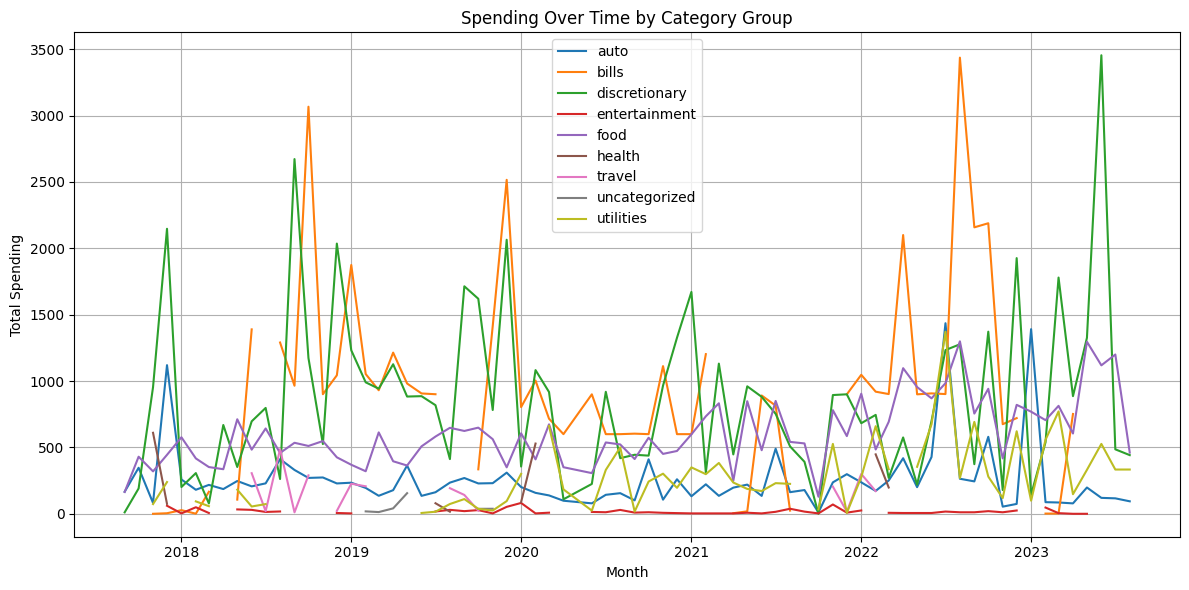

In [35]:
result = df_sum_cat_monthly

# Convert the 'Month' column to a datetime object for proper sorting
result['Month'] = pd.to_datetime(result['Month'])

# Pivot the data to create separate columns for each category_group
pivot_result = result.pivot(index='Month', columns='category_group', values='Total_Spending')

# Create a line graph
plt.figure(figsize=(12, 6))
for category_group in pivot_result.columns:
    plt.plot(pivot_result.index, pivot_result[category_group], label=category_group)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Total Spending')
plt.title('Spending Over Time by Category Group')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
## Top five expenses per category per month

df_sum_cat_monthly = pd.read_sql('''WITH RankedTransactions AS (
    SELECT
        strftime('%Y-%m', DATE) AS Month, category, cat2 as category_group, description, amount,
        RANK() OVER (PARTITION BY cat2, strftime('%Y-%m', Date) ORDER BY Amount DESC) AS ChargeRank
    FROM
        clean
    WHERE 1=1 
    AND Transaction_Type = 'debit'
    AND amount > 300
    AND outliers = 0
)

SELECT *
FROM RankedTransactions
WHERE ChargeRank <= 3
-- AND month = ''
AND category_group = 'bills'
;''', conn) 

df_sum_cat_monthly


,Month,category,category_group,description,amount,ChargeRank
0,2018-06,credit card payments,bills,ach trans - select rwds pymt;060418;payment,757.55,1
1,2018-08,mortgage & rent,bills,ach trans - jeremy lehman ;080718;fee $00.75,900.75,1
2,2018-08,credit card payments,bills,ach trans - select rwds pymt;080218;payment,301.19,2
3,2018-09,mortgage & rent,bills,ach trans - jeremy lehman ;090418;fee $00.75,900.75,1
4,2018-10,credit card payments,bills,ach trans - select rwds pymt;100318;payment,1124.22,1
5,2018-10,mortgage & rent,bills,ach trans - jeremy lehman ;100218;fee $00.75,900.75,2
6,2018-10,credit card payments,bills,ach trans - select rwds pymt;101518;payment,870.00,3
7,2018-11,mortgage & rent,bills,ach trans - jeremy lehman ;110218;fee $00.75,900.75,1
8,2018-12,mortgage & rent,bills,ach trans - jeremy lehman ;120318;fee $00.75,900.75,1
9,2019-01,credit card payments,bills,ach trans - select rwds pymt;011719;payment,967.61,1


In [37]:
## Avg mo. expense per cat category
# df_avg_mo_cat = pd.read_sql('''SELECT 
#                                   cat2
#                                   , sum(Amount) AS Average_Spending
#                                 FROM    clean
#                                 WHERE 1=1 
#                                     AND Transaction_Type = 'debit'
#                                     AND outliers = 0
#                                     and category like '%rent%'
#                                     --and cat2 like '%food%'
#                                     and Date like '%2022%' 
#                                 GROUP BY  cat2
#                                 ORDER BY  cat2
#                                 ''', conn) 

# df_avg_mo_cat
# ----------------------------------------------------------------------------------------

df_avg_mo_cat = pd.read_sql('''SELECT cat2, avg(Average_Spending) AS Average_Spending 
                               FROM 
                               (
                                    SELECT 
                                        cat2
                                        , strftime('%Y-%m', Date) AS Month
                                        , sum(Amount) AS Average_Spending
                                    FROM    clean
                                    WHERE 1=1 
                                        AND Transaction_Type = 'debit'
                                        AND outliers = 0
                                        -- and category like '%rent%'
                                        -- and cat2 like '%food%'
                                        and cat2 <> 'transfer'
                                        and Date like '%2022%' 
                                    GROUP BY  Month, cat2 
                                    ) sub
                                    GROUP BY cat2 
                                    ORDER BY cat2
                                 ''', conn) 

df_avg_mo_cat.to_csv('monthly_avg_debit_category.csv', index=False)

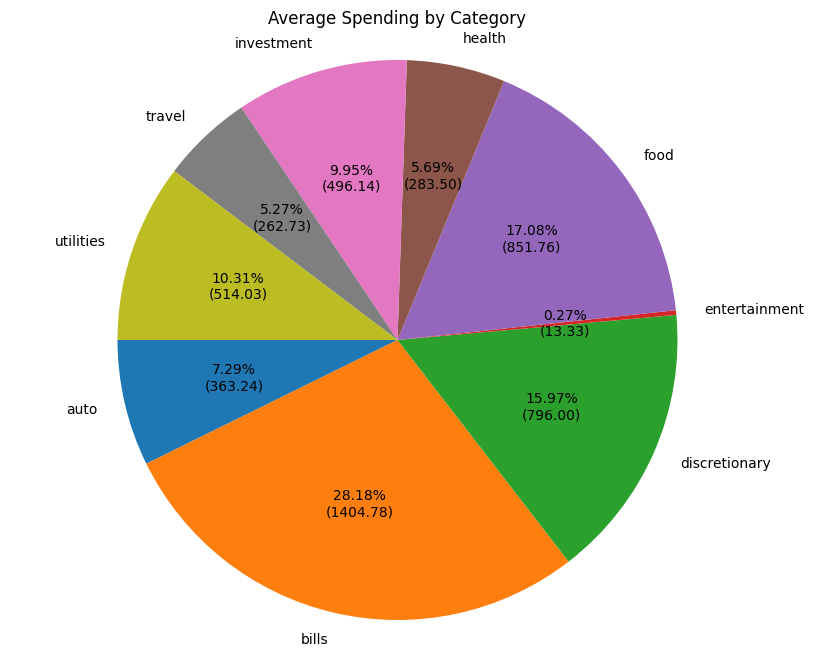

In [38]:

# Extract the relevant columns
categories = df_avg_mo_cat['cat2']
average_spending = df_avg_mo_cat['Average_Spending']

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(average_spending, labels=categories, autopct=lambda p: f'{p:.2f}%\n({p * sum(average_spending) / 100:.2f})', startangle=180)
plt.title("Average Spending by Category")


# Display the pie chart
plt.axis('equal')
plt.show()

In [39]:
# Daily spending by Food category
df_food_cat = pd.read_sql('''SELECT
    Date,
    SUM(CASE WHEN Category = 'restaurants' THEN Amount ELSE 0 END) AS restaurants,
    SUM(CASE WHEN Category = 'groceries' THEN Amount ELSE 0 END) AS groceries,
    SUM(CASE WHEN Category = 'fast food' THEN Amount ELSE 0 END) AS fast_food,
    SUM(CASE WHEN Category = 'coffee shops' THEN Amount ELSE 0 END) AS coffee_shops,
    SUM(CASE WHEN Category = 'pharmacy' THEN Amount ELSE 0 END) AS pharmacy
FROM
    clean
WHERE
    Transaction_Type = 'debit'
    AND outliers = 0
    AND Cat2 LIKE '%food%'
    AND Date > '2022-01-01'
GROUP BY
    Date
ORDER BY
    Date;''', conn) 

df_food_cat.to_csv('monthly_food_category.csv', index=False)

### Identify Outliers

In [80]:

# Define a threshold for IQR-based outliers
# iqr_threshold = 1.5  # You can adjust this threshold as needed
# iqr_threshold = 3  # 5% 
iqr_threshold = 6  # 1% 

# Group the data by the 'Cat2' column (category)
grouped_data = clean_data.groupby('Cat2')

# Initialize an empty DataFrame to store outliers
outliers = pd.DataFrame()

# Loop through each category group
for category, group in grouped_data:
    # Calculate the first quartile (Q1) and third quartile (Q3) for the 'Amount' column
    q1 = group['Amount'].quantile(0.25)
    q3 = group['Amount'].quantile(0.75)

    # Calculate the IQR for this category
    iqr = q3 - q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr

    # Identify and append outliers for this category
    category_outliers = group[(group['Amount'] < lower_bound) | (group['Amount'] > upper_bound)]
    outliers = outliers.append(category_outliers)

outliers.to_csv('outliers.csv', index=False)

outliers

,Date,Description,Original_Description,Amount,Transaction_Type,Category,Account_Name,Labels,Notes,Year,Month,outliers,Cat2
475,2023-01-11,darrell waltrip 5511 tn frankl...,darrell waltrip 5511 tn frankl...,1163.23,debit,service & parts,checking,NaN,NaN,2023,1,0,auto
890,2022-07-25,darrell waltrip 5511 tn frankl...,darrell waltrip 5511 tn frankl...,1000.76,debit,service & parts,checking,NaN,NaN,2022,7,0,auto
4935,2017-12-22,belle meade serv 7538 tn nashville belle mead...,belle meade serv 7538 tn nashville belle mead...,804.65,debit,service & parts,checking,NaN,NaN,2017,12,0,auto
1091,2022-04-27,ach trans - irs treas 310 ;042722; tax ref,ach trans - irs treas 310 ;042722; tax ref,2762.82,credit,federal tax,checking,NaN,NaN,2022,4,0,bills
2395,2020-07-08,ach trans - irs treas 310 ;070920; tax ref,ach trans - irs treas 310 ;070920; tax ref,5488.00,credit,federal tax,savings,NaN,NaN,2020,7,0,bills
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545,2019-04-17,trans cd - transfer to certificate 1904171,trans cd - transfer to certificate 1904171,16738.28,debit,transfer,savings,NaN,NaN,2019,4,0,transfer
4415,2018-06-17,transfer - self service transfer from tbcrozie...,transfer - self service transfer from tbcrozie...,15000.00,credit,transfer,savings,NaN,NaN,2018,6,0,transfer
281,2023-04-17,ach trans - select rwds pymt;041723;payment,ach trans - select rwds pymt;041723;payment,860.03,debit,uncategorized,checking,NaN,NaN,2023,4,0,uncategorized
1399,2021-12-22,ach trans - oculoplastic spe;122121;online pmt,ach trans - oculoplastic spe;122121;online pmt,265.50,debit,uncategorized,checking,NaN,maybe credit card,2021,12,0,uncategorized


# Sandbox

## *[DEBUG]*